### Overview of Probem (Alignment of Image)

The problem of image alighnment can solved in two ways: one through supervised way and another through unsupervised way.
- **Unsupervised** : 
    - Detecting Line
        - We first find line segments in a binary image using the probabilistic Hough transform. Then calculate the angle between the line detected and X-axis which determine the angle of alignment. We rotate the image by the angle we obtained from prior process. It works for image which contains lines in image.
    - Detecting the block of text
        - For this we determine text skew angle and rotate the image by the computed angle. It works for image which contains texts in image.

2. **Supervised** : For this we need already aligned image i.e target image which we will extracting feature from two images and aligning based on those image. In a typical image alignment problem we have two images of a scene, and they are related by a motion model. We need to estimate the parameters of these motion models using different tricks and assumptions. Once these parameters are known, warping one image so that it aligns with the other is straight forward. It is usually not pragmatic since it requires target image.


### Unsupervised Approach

#### a. Detecting Lines

In [1]:
from __future__ import print_function
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import ndimage,stats



In [2]:
def mode(array):
    """
    returns mode of array
    """
    return list(stats.mode([1.1,1.2,1.3,1.3]).mode)[0]

In [3]:
def get_images_list_path():
    images = []
    for file in glob.glob("./images/*.jpg"):
        images.append(file)
    return images

def get_image_file_names(path='./images'):
    return os.listdir(path)

In [4]:
def show_img(img,file=True):
    """
    show image by maptlotlib. Accepts matrix image or file_path
    """
    # if filepath read image first
    if file:
        img = cv2.imread(img, cv2.IMREAD_COLOR)
    plt.figure(figsize = (20,15))
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
    
def concat_image(img1,img2,axis=1):
    """
    concat two image, axis =1 : horizontal , 0:vertical
    """
    return np.concatenate((img1, img2), axis=1)

In [5]:
def calculate_angle(file_path, align_mode='median'):
    img = cv2.imread(file_path)
    # converting image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # detect edges
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    # detect lines thorugh HoughLinesP
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)
    angles = []

    for line in lines:
        x1 ,y1 ,x2, y2 = line[0][0], line[0][1], line[0][2],line[0][3]
        # draw line in image
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
        # converting radian to degree
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)
    
    #print("angles:",angles)
    if align_mode=='median':
        align_angle = np.median(angles)
    elif align_mode=='mode':
        align_angle = mode(angles)
        
    return align_angle , img

def rotate_img(img,angle):
    img = cv2.imread(img)
    # rotate the image to deskew it
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

In [6]:
def create_dir(dir_name='aligned_images'):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    return True

def get_name_only(file_name):
    return file_name.split('.')[0]

In [7]:
def align_image(img_name,target_dir='./aligned_images/'):
    path = './images/'+img_name
    print("Procesing image:",path)
    angle, img_after = calculate_angle(path)
    aligned = rotate_img(path,angle)
    aligned_path = target_dir+get_name_only(img_name)+'_aligned.jpg'
    cv2.imwrite(aligned_path, aligned)
    print("Aligned image saved at:",aligned_path)
    return aligned_path

#### b. Detecting the block of text

Here we align the images by detecting the block of text, finding the screwness of text and rotating the image

In [9]:
def align_img_by_text(img_path):
    image = cv2.imread(img_path)
    # convert the image to grayscale and flip the foreground
    # and background to ensure foreground is now "white" and
    # the background is "black"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
 
    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
     
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
     
    # otherwise, just take the inverse of the angle to make positive
    else:
        angle = -angle
        
    print("[INFO] angle: {:.3f}".format(angle))

    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

[INFO] angle: 1.200


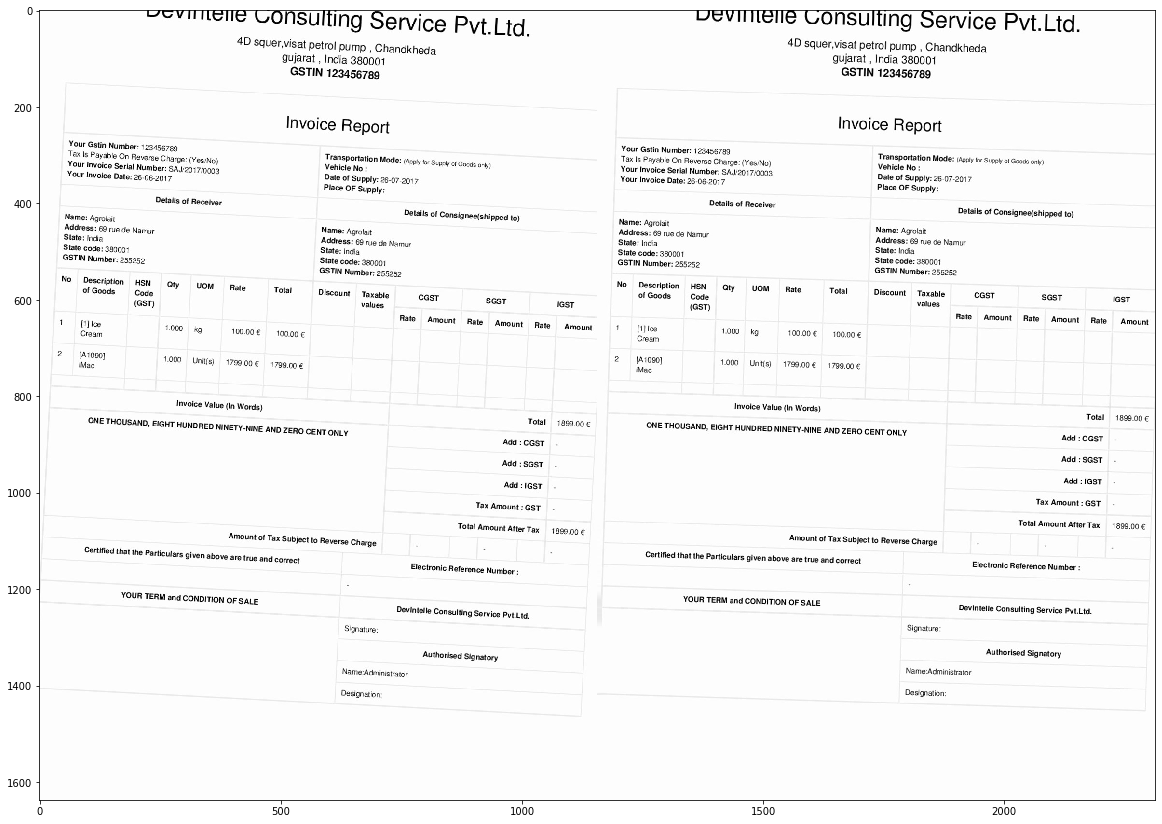

In [10]:
img_path = "./images/7.jpg"
img_raw  = cv2.imread(img_path)
show_img(concat_image(img_raw,align_img_by_text(img_path)),file=False)

In [11]:
def align_image_save(img_name,target_dir='./aligned_images2/'):
    path = './images/'+img_name
    print("Procesing image:",path)
    aligned = align_img_by_text(path)
    aligned_path = target_dir+get_name_only(img_name)+'_aligned.jpg'
    cv2.imwrite(aligned_path, aligned)
    print("Aligned image saved at:",aligned_path)
    return aligned_path

In [13]:
def process_images(images_path,approach=1):
    for image in images_path:
        if approach == 1:
            _ = align_image(image)
        elif approach == 2:
            _ = align_image_save(image)
    return True

#### Aligning image using first approach i.e detecting lines

In [15]:
process_images(get_image_file_names(),approach=1)

Procesing image: ./images/law-firm-invoice-template.jpg
Aligned image saved at: ./aligned_images/law-firm-invoice-template_aligned.jpg
Procesing image: ./images/0f97914844b786b0d2ef21339286cdf6 - 2.jpg
Aligned image saved at: ./aligned_images/0f97914844b786b0d2ef21339286cdf6 - 2_aligned.jpg
Procesing image: ./images/10.jpg
Aligned image saved at: ./aligned_images/10_aligned.jpg
Procesing image: ./images/6 2.jpg
Aligned image saved at: ./aligned_images/6 2_aligned.jpg
Procesing image: ./images/5f228310d55c683ed29aa8c0adda7efc.jpg
Aligned image saved at: ./aligned_images/5f228310d55c683ed29aa8c0adda7efc_aligned.jpg
Procesing image: ./images/AWT009.jpg
Aligned image saved at: ./aligned_images/AWT009_aligned.jpg
Procesing image: ./images/4.jpg
Aligned image saved at: ./aligned_images/4_aligned.jpg
Procesing image: ./images/billing-invoice-for-legal-services.jpg
Aligned image saved at: ./aligned_images/billing-invoice-for-legal-services_aligned.jpg
Procesing image: ./images/5.jpg
Aligned im

True

#### Aligning image using second approach i.e detecting text skewness

In [16]:
process_images(get_image_file_names(),approach=2)

Procesing image: ./images/law-firm-invoice-template.jpg
[INFO] angle: 1.469
Aligned image saved at: ./aligned_images2/law-firm-invoice-template_aligned.jpg
Procesing image: ./images/0f97914844b786b0d2ef21339286cdf6 - 2.jpg
[INFO] angle: -2.598
Aligned image saved at: ./aligned_images2/0f97914844b786b0d2ef21339286cdf6 - 2_aligned.jpg
Procesing image: ./images/10.jpg
[INFO] angle: -0.578
Aligned image saved at: ./aligned_images2/10_aligned.jpg
Procesing image: ./images/6 2.jpg
[INFO] angle: -0.326
Aligned image saved at: ./aligned_images2/6 2_aligned.jpg
Procesing image: ./images/5f228310d55c683ed29aa8c0adda7efc.jpg
[INFO] angle: 0.000
Aligned image saved at: ./aligned_images2/5f228310d55c683ed29aa8c0adda7efc_aligned.jpg
Procesing image: ./images/AWT009.jpg
[INFO] angle: 2.198
Aligned image saved at: ./aligned_images2/AWT009_aligned.jpg
Procesing image: ./images/4.jpg
[INFO] angle: 1.469
Aligned image saved at: ./aligned_images2/4_aligned.jpg
Procesing image: ./images/billing-invoice-for

True

### Supervised Approach

In [17]:
MAX_MATCHES = 500
GOOD_MATCH_PERCENT = 0.15

In [18]:
def rotate_image(img,angle):
    """
    function to rotate image by certain angle
    img : image matrix
    angle : angle to rotate
    returns: rotated image matrix
    """
    # openCV
    M = cv2.getRotationMatrix2D((0, 0), angle, 1)
    height, width, channels = img.shape
    return cv2.warpAffine(img, M, (width, height))

In [19]:
def alignImages(im1, im2):

    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
  
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_MATCHES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
  
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)# Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)
    
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    
    # Find homography, matrix to warp the image using points between two image
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    # Use homography
    height, width, channels = im2.shape
    # warp the image using homographic matrix h
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    
    return im1Reg, h

In [20]:
def compute_alignment(ref_image,source_image,outFilename="result3.jpg"):
    # ref image
    imReference = cv2.imread(ref_image, cv2.IMREAD_COLOR)
    # source image
    im = cv2.imread(source_image, cv2.IMREAD_COLOR)
    imReg, h = alignImages(im, imReference)
    
    cv2.imwrite(outFilename, imReg)
    
    return imReg
    

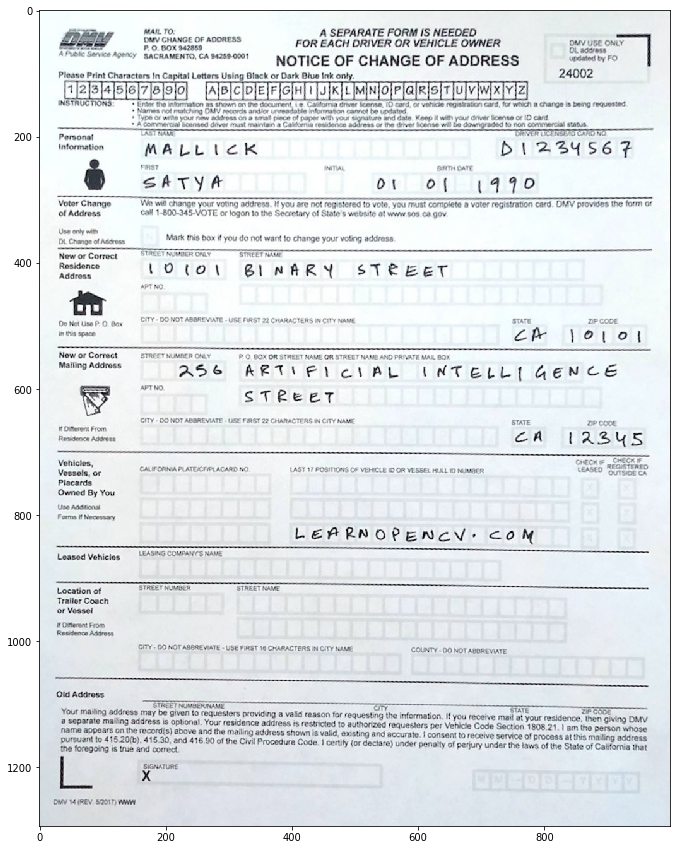

In [23]:
show_img(compute_alignment('form.jpg','scanned-form.jpg'),file=False)